## Gait Analysis on  WISDM Dataset

###  ML Model

In [1]:
##model_wisdm.py
import numpy as np
import pandas as pd
#import seaborn as sns

#preprocess data 
def preprocess(data):
    #column_names = ['user_id','activity','timestamp', 'x_axis', 'y_axis', 'z_axis']
    df = pd.read_csv(data,on_bad_lines='skip',index_col=False)
    df.columns= ['user_id','activity','timestamp', 'x_axis', 'y_axis', 'z_axis']
    df = df.dropna() # removing null values
    df['z_axis'].replace(regex=True, inplace=True, to_replace=r';', value=r'') # Transforming the z-axis to float
    
    #### Label encoding 
    from sklearn.preprocessing import LabelEncoder
    label = LabelEncoder()
    df['label'] = label.fit_transform(df['activity'])
    
    ##Balanace this Data :Under sampling
    Walking = df[df['activity']=='Walking'].head(48394).copy()
    Jogging = df[df['activity']=='Jogging'].head(48394).copy()
    Upstairs = df[df['activity']=='Upstairs'].head(48394).copy()
    Downstairs = df[df['activity']=='Downstairs'].head(48394).copy()
    Sitting = df[df['activity']=='Sitting'].head(48394).copy()
    Standing = df[df['activity']=='Standing'].copy()
    
    #df_balanced = pd.DataFrame()
    df_balanced = pd.concat([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
    
    ##Normalize/Standardized data
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    X = df_balanced[['x_axis', 'y_axis', 'z_axis']]
    target = df_balanced['label']
    scaler = StandardScaler()
    dx = scaler.fit_transform(X)
    df_scaled = pd.DataFrame(data = dx, columns = X.columns)
    df_scaled['label'] = target.values
    return df_scaled

In [2]:
dff=preprocess('C:/Datasets/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')
#dff.head()

C:\Users\adanent\Anaconda3\envs\Annotation_tool\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
## Segmenting samples (windowing) functions 
import scipy.stats as stats
Fs = 20
segment_size =  500# Fs*4 # window size=n_time steps=frame size
step_size =  25 # Fs*2  # step size 
n_features = 3     

def get_segments(df, segment_size, step_size):
    segments = []
    labels = []
    for i in range(0, len(df) - segment_size - 1, step_size):
        xs = dff['x_axis'].values[i: i + segment_size]
        ys = dff['y_axis'].values[i: i + segment_size]
        zs = dff['z_axis'].values[i: i + segment_size]
        label = stats.mode(dff['label'][i: i + segment_size])[0][0] # [0][0] shows the index of the current sequence
        #We used the dstack() to ensure that each array is stacked in such a way that
        #the features are separated in the third dimension, as we would prefer.
        segments.append(np.dstack([xs, ys, zs]))
        labels.append(label)

    # Bring the segments into a better shape
    segments=np.asarray(segments, dtype= np.float32).reshape(-1, segment_size, n_features)
    labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
                
    return segments, labels

In [4]:
X, y = get_segments(dff, segment_size, step_size)

In [5]:
X.shape, y.shape

((11595, 500, 3), (11595, 6))

### DeepConvLSTM
A further extension of the CNN-LSTM idea is to perform the convolutions of the CNN (e.g.
how the CNN reads the input sequence data) as part of the LSTM. This combination is called
a Convolutional LSTM, or ConvLSTM for short, and like the CNN-LSTM is also used for
spatiotemporal data. The ConvLSTM2D class, by default, expects input data to have the shape:
**[samples, time, rows, cols, channels]**. Where each time step of data is defined as an
image of (rows × columns) data points.

In CNN-LSTM, we divided a given window of data (128 time steps) into four
subsequences of 32 time steps. We can use this same subsequence approach in defining the
ConvLSTM2D input where the number of time steps is the number of subsequences in the window,
the number of rows is 1 as we are working with one-dimensional data, and the number of
columns represents the number of time steps in the subsequence, in this case 32. For this chosen
framing of the problem, the input for the ConvLSTM2D would therefore be:

1.  **Samples**: n, for the number of windows in the dataset.
2.  **Time**: 4, for the four subsequences that we split a window of 128 time steps into.
3.  **Rows**: 1, for the one-dimensional shape of each subsequence.
4.  **Columns**: 32, for the 32 time steps in an input subsequence.
5.  **Channels**: 3, for the 3 input variables.

In [6]:
# reshape data into time steps of sub-sequences
n_steps, n_length = 10, 50
df_X = X.reshape((X.shape[0], n_steps, n_length, n_features))
n_outputs = y.shape[1] #n_outputs= 6

The ConvLSTM2D class requires configuration both in terms of the CNN and the LSTM. This
includes specifying the number of filters (e.g. 64), the two-dimensional kernel size, in this case
(1 row and 3 columns of the subsequence time steps), and the activation function, in this case
rectified linear. As with a CNN or LSTM model, the output must be flattened into one long
vector before it can be interpreted by a dense layer

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import ConvLSTM2D

In [8]:
#from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split

In [9]:
# split data into training set and test set
X_train_main, X_test, y_train_main, y_test = train_test_split(df_X, y,test_size=0.20, random_state=7)

# split training set into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_main,y_train_main,test_size=0.30,random_state=7)

In [10]:
X_train.shape, X_test.shape,y_train.shape,y_test.shape

((6493, 10, 50, 3), (2319, 10, 50, 3), (6493, 6), (2319, 6))

In [11]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

# reshape data into time steps of sub-sequences
n_steps, n_length,n_features = 10, 50,3

X_train = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
X_valid = X_valid.reshape((X_valid.shape[0], n_steps, 1, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, 1, n_length, n_features))

In [12]:
def create_model(optimizer= 'rmsprop' , init= 'glorot_uniform' ):
    # define convlstm model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3),input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [13]:
### Initialize Model
convLSTM2D=create_model()

In [14]:
history = convLSTM2D.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=50)

Epoch 1/10
130/130 [==============================] - 67s 389ms/step - loss: 0.8712 - accuracy: 0.6462 - val_loss: 0.4173 - val_accuracy: 0.8333
Epoch 2/10
130/130 [==============================] - 50s 383ms/step - loss: 0.3232 - accuracy: 0.8682 - val_loss: 0.2530 - val_accuracy: 0.8944
Epoch 3/10
130/130 [==============================] - 45s 344ms/step - loss: 0.1670 - accuracy: 0.9358 - val_loss: 0.1345 - val_accuracy: 0.9515
Epoch 4/10
130/130 [==============================] - 46s 352ms/step - loss: 0.1000 - accuracy: 0.9638 - val_loss: 0.0742 - val_accuracy: 0.9716
Epoch 5/10
130/130 [==============================] - 46s 355ms/step - loss: 0.0522 - accuracy: 0.9831 - val_loss: 0.0560 - val_accuracy: 0.9838
Epoch 6/10
130/130 [==============================] - 42s 326ms/step - loss: 0.0424 - accuracy: 0.9869 - val_loss: 0.0369 - val_accuracy: 0.9903
Epoch 7/10
130/130 [==============================] - 44s 338ms/step - loss: 0.0314 - accuracy: 0.9921 - val_loss: 0.0219 - val_ac

## Save model

In [15]:
convLSTM2D.save('DeepConvLSTM_400.h5')

###  Evaluate Model

In [16]:
# Make Predictions on test 
y_pred_test = convLSTM2D.predict(X_test) #class Prediction 

y_pred_test[:5], #y_probs_test[:5]

73/73 [==============================] - 14s 128ms/step


(array([[4.6681380e-22, 0.0000000e+00, 1.0000000e+00, 1.1978813e-13,
         5.8344197e-15, 3.4776498e-38],
        [5.0055522e-05, 1.0355382e-07, 1.9638390e-04, 9.9959701e-01,
         1.5620668e-04, 2.0082034e-07],
        [9.8615172e-05, 7.4999207e-09, 2.2881650e-05, 9.5269229e-04,
         9.9892539e-01, 3.5262053e-07],
        [1.5021452e-05, 3.5305519e-16, 9.9908030e-01, 2.4903841e-07,
         9.0446573e-04, 6.3149104e-23],
        [4.6296987e-06, 1.4809865e-07, 2.4346921e-04, 9.9957126e-01,
         1.8038515e-04, 1.7777178e-07]], dtype=float32),)

In [17]:
y_pred_test=np.argmax(y_pred_test,axis=1) 
y_true_test=np.argmax(y_test,axis=1) 

y_true_test.shape, y_pred_test.shape

((2319,), (2319,))

In [18]:
import seaborn as sns
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix,classification_report
cm=confusion_matrix(y_true_test,y_pred_test)
print(cm)
print(acc(y_true_test,y_pred_test))
print(classification_report(y_true_test,y_pred_test))

[[371   1  11   0   9   0]
 [  0 403   0   0   0   0]
 [  1   0 349   4   2   0]
 [  0   0   6 368   0   0]
 [  8   0  13   0 381  12]
 [  0   2   0   0   0 378]]
0.9702457956015524
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       392
           1       0.99      1.00      1.00       403
           2       0.92      0.98      0.95       356
           3       0.99      0.98      0.99       374
           4       0.97      0.92      0.95       414
           5       0.97      0.99      0.98       380

    accuracy                           0.97      2319
   macro avg       0.97      0.97      0.97      2319
weighted avg       0.97      0.97      0.97      2319



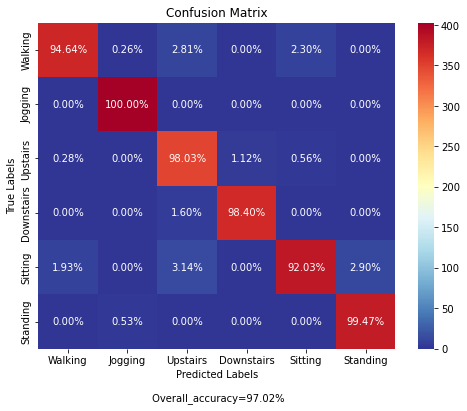

In [19]:
cf=np.empty((6,6))
for i in range(6):
    cf[i]=(cm[i]/np.sum(cm[i]))
    
# group_counts = ["{0:.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()]
labels = [f"{v1}" for v1 in group_percentages]
labels = np.asarray(labels).reshape(6,6)

fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
sns.heatmap(cm, annot=labels,fmt="",cmap='RdYlBu_r',ax=ax)
ax.set_xlabel("Predicted Labels\n\n Overall_accuracy=""{0:.2%}".format(acc(y_true_test,y_pred_test)))
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(['Walking','Jogging','Upstairs','Downstairs','Sitting','Standing'])
ax.yaxis.set_ticklabels(['Walking','Jogging','Upstairs','Downstairs','Sitting','Standing'])
plt.savefig('ConfusionMatrix_Ensem-HAR_WISDM',dpi=1200, bbox_inches='tight')

In [20]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true_test, y_pred_test, average='macro')

(0.9700313017763031, 0.9709582610848867, 0.9701523773084215, None)